## Understanding Forecast Quality

Aim of any forecasting system is to improve the decision-making framework through future predictions using past experiences _i.e._ data. Although, for many practical purposes like reporting and decision making we use a single-valued point forecast, there are scenarios where prediction intervals from probabilistic forecasts can aid decision making by calculating associated risk.

In describing the quality of forecast _accuracy_, _error_ and _loss_ are some general metrics that are often quoted to choose between two competing forecasting models. Errors can be monitored at two levels a) business metrics b) model performance. It is imperative to monitor both these metrics to track the change for every cycle of predictions to understand the drift (or depletion of forecast quality). A substantial change in any of the metrics should be investigated as it might lead to the nature of model's [mis]behaviour.

Here, I discuss various metrics which can be used "together" to avoid the pitfalls related to optimizing a single metric. Following a single metric alone can be misleading when it comes to the quality of forecast as it might be practically useless despite the stellar performance of that particular metric. It is practically impossible to reduce all error metrics to only one dimension without sacrificing information since each metric gives us complementary information about the forecast.

For us, the important question at hand is to decide between two competing forecasts based on the error.  The issue gets accented when quantifying the quality of thousands of time-series predicted in one shot as it limits our ability to check each one individually. Hence we resort to the aggregate error statistics. Ideally, a replacing forecasting system with reliable predictions should improve all error metrics w.r.t existing benchmark. Moreover, the replacing system should ultimately serve the goals of the organization whatever the metrics be.


### Error metrics for point forecasts
Most of these metrics are drawn from user manual of [M5 competition](https://usermanual.wiki/Document/M4CompetitorsGuide.1491768831/html).

#### MAPE + BIAS + absolute_error

`MAPE`(Mean Absolute Percentage Error) is the most identifiable and often quoted business metric. In the implementation, tolerance is used to avoid `NaN`s.
    
```python
import numpy as np

def mape_and_bias(true, predict, tol=1e-10):
    error = predict-true
    bias = error/(true+tol)
    abs_error = np.abs(error)
    mape = abs_error/(np.abs(true)+tol)
    return mape, bias, abs_error # caped mape: min(mape,1)
```

    
##### Weighted MAPE or wMAPE
A single weighted value for `MAPE` is required when comparing two different algorithms/forecasting systems invovling multiple timeseries. For example if there are 100 timeseries, sum of weighted `MAPE` is calculated as $wMAPE = \sum_{i=1}^{100}w_{i}\times MAPE_{i}$. Another non-dimensional measure can be calculated as $ND = \frac{\sum_{i}forecast_{i}}{\sum_{i}actuals_{i}}$

#### Symmetric MAPE or sMAPE

Symmetric MAPE is a useful metric when actuals/predictions are close to `0`. `sMAPE` addresses the situation of exploding error metric through division when denominator $ \rightarrow 0 $. A weighted value can be calulated as in the case of `wMAPE` as well.

```python
def smape(true, predict, tol=1e-10):
    denominator = np.abs(target) + np.abs(forecast) + tol
    return 2*np.abs(target - forecast) / denominator
```

####  RMSE and Normalized RMSE

RMSE _a.k.a_ Root Mean Squared Error is the _L2_ version of MAPE, and it can be normalized by absolute error to get a normalized value `nRMSE`.

```python

def rmse_and_nrmse(true, predict):
    error = predict-true
    rmse = np.mean(np.sqrt(error^2))
    abs_error = np.mean(np.abs(error))
    nrmse=rmse/abs_error
    return rmse, nrmse
```

####  MASE - Mean Absolute Scaled Error

MASE help to calculate the value-added through a forecasting system by comparing to a naive forecast _i.e_ a forecast from the training example. This is a relative measure of our forecasting system _w.r.t_ a [naive](https://otexts.com/fpp2/accuracy.html#scaled-errors) estimate. 

```python
def mase(true, predict, naive_forecast):
    return np.mean(np.abs(true - predict)) / np.mean(np.abs(true - naive_forecast))
```

####  OWA - Overall Weighted Average
This is a metric popularized by M-competitions to rank the competitors. Here a naive forecast is created by taking the median value from the past season, _i.e._ for a naive forecast of _Jan 2020_, we can take the median value of _Jan-2019_, _Jan-2018 etc_. All error metrics mentioned can be calculated w.r.t actuals from the naive forecast to create a naive estimate. 

$$OWA = 0.5*\left(\frac{sMAPE}{sMAPE_{naive}} + \frac{MASE}{MASE_{naive}}\right)$$

### Error metrics for probabilistic forecasts

There are some instances where some key decisions are made based on the uncertainty in the forecast and it is vital to assess forecast quality using prediction intervals from distribution rather than point estimates. I aim to create a reasonable intuition on interpreting these metrics. All the errors discussed in the point forecasts can be calculated for probabilistic forecasts by choosing a midpoint such as the median or the mean.

#### Quantile Loss and Coverage

Quantiles divide a probability distribution into regions of equal probability. Quantile loss measure the deviation of each predicted quantile (thereby learning the whole distribution) from the target and should be seen in the context of "coverage". Coverage gives the proportion of predictions north of actuals hence we can estimate whether each quantile is under/over forecasting. For an accurately predicted distribution, higher quantiles should give higher coverage as they give a higher expectation than the median and vice versa.

```python
## coverage
def coverage(target, forecast):
    return (np.mean((target < forecast)))

## quantile loss
def quantile_loss(target, forecast, q):
    return (2*np.sum(np.abs((forecast-target)*((target<=forecast)-q))))
```

[Figure](#image) gives an intuition of how loss and coverage changes for various learned distribution for a given target.

![Alt text][image]

##### weighted loss

Weighted Quantile loss for a given quantile _q_ is calculated with division by sum of absolute target, _i.e._ absolute sum of the target.


$$ wQuantileLoss_{q}=\frac{QuantileLoss_{q}}{\sum_{i}actuals_{i}}$$


#### MSIS - Mean Scaled Interval Score

Simillar to MASE, MSIS compares the forecast error to a baseline seasonal_error calculated from naive forecast.

```python

def msis(target,lower_quantile,upper_quantile,seasonal_error,alpha):
    """alpha - significance level"""

        numerator = np.mean(
            upper_quantile-lower_quantile
            + 2.0/ alpha* (lower_quantile - target)*(target < lower_quantile)
            + 2.0/ alpha*(target - upper_quantile)*(target > upper_quantile)
        )
        return (numerator/seasonal_error)
```

## Conclusion

With all things mentioned above, a refined forecasting system must reflect the distinct costs of underprediction and overprediction. For example, over-forecasting is costly when a factory produce an item(like drugs) with a short expiry date as we may have lesser opportunities to sell it before expiration leaving it wasteful. In such cases, we need to approach the target from below and under forecasting has to be favored. On the other hand, over forecasting is favorable for certain generic products which are stable for a longer duration. Such items can be produced without disruption and stocked-up if inventory cost is reasonable, thus giving us more opportunities to sell them in the market. The degree of tuning this bias to favor in either direction depends on the organization, capacity, economic climate, and other factors. Due to such dynamic pressures, it is challenging to maintain a good forecasting system without constant oversight and monitoring.

## References

1. https://usermanual.wiki/Document/M4CompetitorsGuide.1491768831/html
2. https://otexts.com/fpp2/accuracy.html


[image]:'loss_distro.png' "Qunatile Loss expalnined for various distributions"

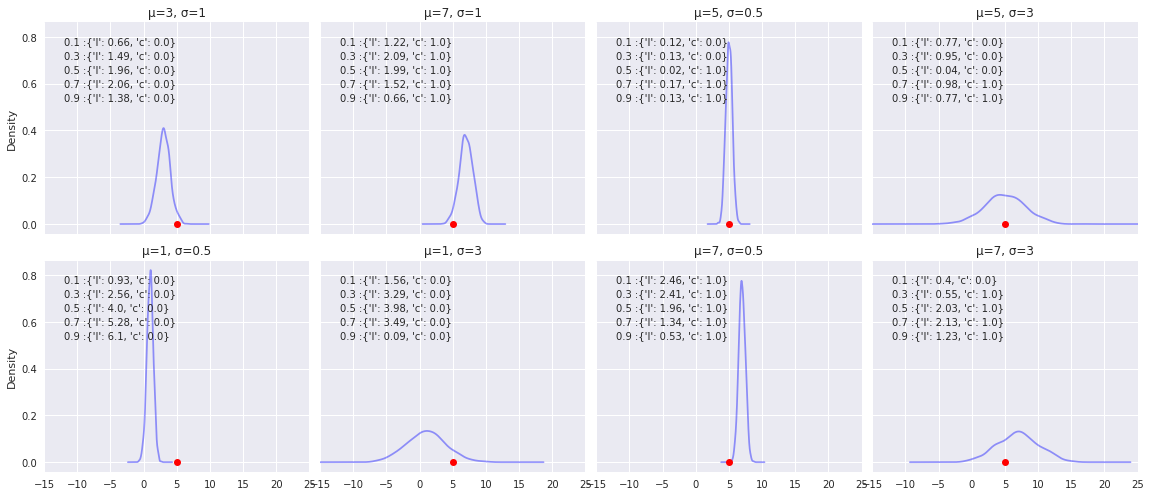

<Figure size 576x396 with 0 Axes>

In [334]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

mu_sigmas = [(3,1),(7,1),(5,0.5),(5,3),(1,0.5),(1,3),(7,0.5),(7,3)]

preds = {'_'.join(map(str,c)):np.random.normal(c[0],c[1],1000) for c in mu_sigmas}
actuals = {'actual_dist':np.random.normal(5,1,1000)}

pred_df = pd.DataFrame(preds)
act_df = pd.DataFrame(actuals)

## coverage
def coverage(target, forecast):
    return (np.mean((target < forecast)))

## quantile loss
def quantile_loss(target, forecast, q):
    loss = 2*np.sum(np.abs((forecast-target)*((target<=forecast)-q)))
    return round(loss,2)

target = 5
quantiles = [0.1,0.3,0.5,0.7,0.9]

loss_dict = {}
for p, vals in preds.items():
    loss_ = {}
    for q in quantiles:
        pred = np.quantile(vals, q)
        loss_[q]={'l':quantile_loss(target,pred,q),'c':coverage(target,pred)}
    loss_dict[p]=loss_

with plt.style.context('seaborn'):
    ax = pred_df.plot(kind='kde', subplots=True, color='b', legend=False, alpha=0.4,
                      sharey=True, sharex=True, layout=(2,4), figsize=(16,7))

    for a, col in zip(ax.flatten(),pred_df.columns):
    #     act_df.plot(kind='kde', color='r',ax=a, legend=False)
        a.plot([5],[0],marker='o',color='r')
        a.set_title("\u03BC={0}, \u03C3={1}".format(*col.split('_')))
        for q in quantiles:
            a.text(-12,0.8-q*0.3,f"{q:1.1f} :{loss_dict[col][q]}")

    plt.xlim(-15,25)
    plt.tight_layout()
    plt.show()
    plt.savefig('loss_distro.png', dpi=100,
                orientation='portrait', papertype=None, format='png',
                transparent=True, bbox_inches=None, pad_inches=0.2, metadata=None)

In [ ]:
## plot Quantile loss vs error for each quantile
# Lets say your target=5, then how will the loss

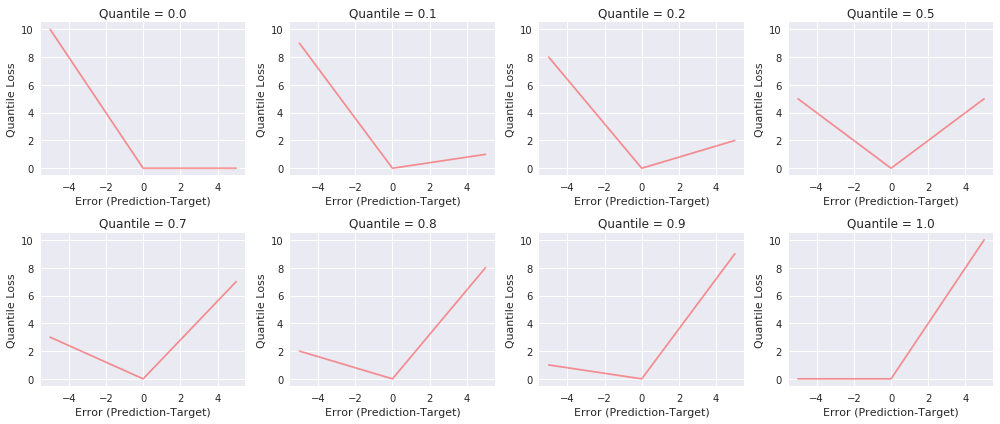

In [400]:
with plt.style.context('seaborn'):
    quant = [0.0,0.1,0.2,0.5,0.7,0.8,0.9,1.0]
    target = 5

    p_lst = np.arange(0,11)
    error_lst = p_lst-target


    fig, ax = plt.subplots(nrows=2, ncols=4 , figsize=(14,6))

    for i, ax in enumerate(ax.flatten()):
        loss_lst = [quantile_loss(p,target,quant[i]) for p in p_lst]
        ax.plot(error_lst,loss_lst,color='r', alpha=0.4)

        ax.set_title(f"Quantile = {quant[i]}")

        ax.set_ylabel("Quantile Loss")
        ax.set_ylim(-0.5,10.5)

        ax.set_xlabel("Error (Prediction-Target)")
        ax.set_xlim(-5.5,5.5)

    plt.tight_layout()
    plt.show()